# **Prefetch의 특징**

- **Prefetch는 여러 가지 의미로 사용**.
  - Row Prefetch : 한 번의 Fetch Call로 Array 크기만큼 여러 개 레코드를 가져오는 것.
  - Prefetch는 테이블 Prefetch와 인덱스 Prefetch가 있음.

- 모든 DBMS는 디스크 블록을 읽을 때 곧이어 읽을 가능성이 높은 블록을 미리 읽는 Prefetch 기능을 제공.
- 디스크 I/O가 비용이 크기 때문에 한번의 I/O Call을 통해 다량의 블록을 퍼 올리면 성능향상에 도움이 됨.
- 곧 읽을 가능성이 높은 블록들을 미리 적재했을 때만 성능 향상에 도움이 됨.
- **Multiblock I/O**
  - prefetch 기능 중 하나.
  - 한번의 I/O Call로써 서로 인접한 블록들을 같이 읽어 적재하는 것.

- 테이블 Prefetch와 인덱스 Prefetch는 인접하지 않은 블록, 즉 서로 다른 익스텐트에 위치한 블록을 배치방식으로 미리 적재하는 것.

- I/O Call을 병렬 방식으로 동시에 여러 개 수행하는 것이므로 읽어야 할 블록들이 서로 다른 디스크 드라이브에 위치한다면 Prefetch에 의한 성능 향상은 더욱 좋아짐.

- Prefetch된 블록들을 모니터링하는 기능은 CKPT 프로세스가 맡는다.
아래 쿼리를 통해 확인할 수 있다.



```sql
select name, value from v$sysstat
where name in ('physical reads cache prefetch','prefetched blocks aged out before use');
NAME                                                                  VALUE
---------------------------------------------------------------- ----------
physical reads cache prefetch                                     344772803
prefetched blocks aged out before use                              38767867
```


- 읽을 블록들을 미리 적재하는 기능이므로 시스템 전반의 디스크 경합을 줄여주기보다, 개별 쿼리의 수행 속도를 향상시키는데 주로 도움을 줌.
- 데이터 블록을 읽는 도중에 물리적인 디스크 I/O가 필요할 때 서버 프로세스는 I/O 서버시스템에 I/O Call을 발생시키고 잠시 대기 상태가 됨.
- 이 때 ,곧이어 읽을 가능성이 높은 블록들을 버퍼 캐시에 미리 적재해 놓으면 대기 이벤트 발생횟수를 줄이게 됨.

# **인덱스 Prefetch**

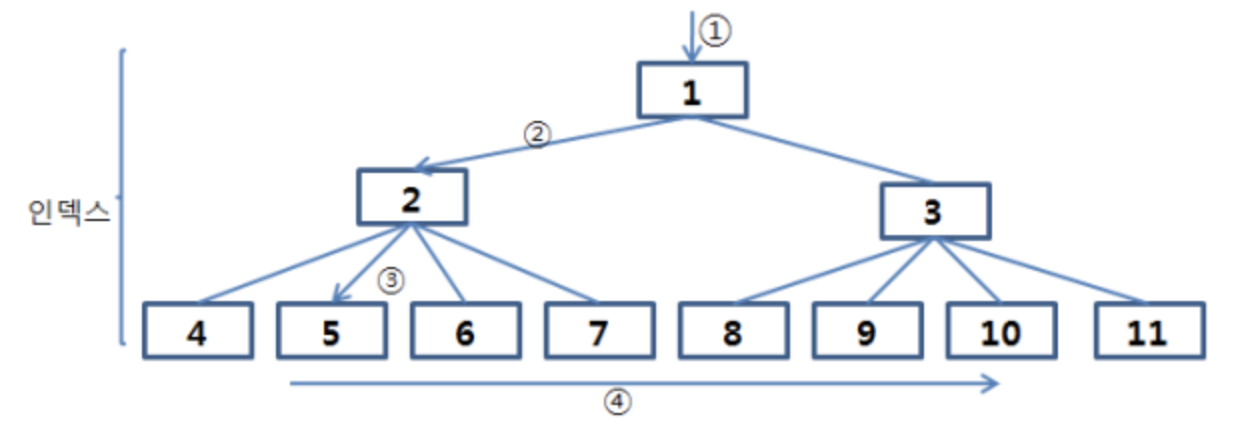

- 브랜치 블록에서 앞으로 읽게 될 리프 블록 주소를 미리 얻을 수 있으므로 I/O Call이 필요한 시점에 미리 캐싱해 두는 것이 가능.

<br>

1. ex

- ① -> ② -> ③ -> ④ 순으로 Index Range Scan을 진행한다고 가정.
- 2번 브랜치 블록을 읽고 5번 리프 블록을 읽으려는 시점에 5번 블록이 버퍼 캐시에 없으면 물리적인 디스크 I/O가 필요.
- 이때, 6번과 7번 블록까지 같이 적재해 놓으면 ④번 리프 블록 스캔이 진행하는 동안 디스크 I/O 때문에 대기할 가능성을 줄임.

<br>

2. 인덱스 Prefetch 기능이 효과적인 경우

  **인덱스 Prefetch 기능이 가장 효과적일 수 있는 상황은 Index Full Scan이 일어날 때**

- 부분범위처리 방식으로 중간에 멈추지만 않는다면 모든 인덱스 리프 블록을 읽게 되기 때문.

- 그러나 Index Full Scan시 Prefetch 방식으로 I/O하려면 리프 블록 위쪽에 있는 브랜치 블록들을 추가로 읽어야 하기 때문에 I/O가 약간 더 발생.

  **Prefetch를 제어하는 파라미터**

- _index_prefetch_factor : 기본값은 100이며, 이 값을 더 작게 설정할수록 옵티마이저는 인덱스 Prefetch를 더 선호하게 됨.

- _db_file_noncontig_mblock_read_count : 한번에 최대 몇 개 블록을 Prefetch 할지를 지정하며 1로 지정하면 Prefetch 기능이 정지.

# **테이블 Prefetch**

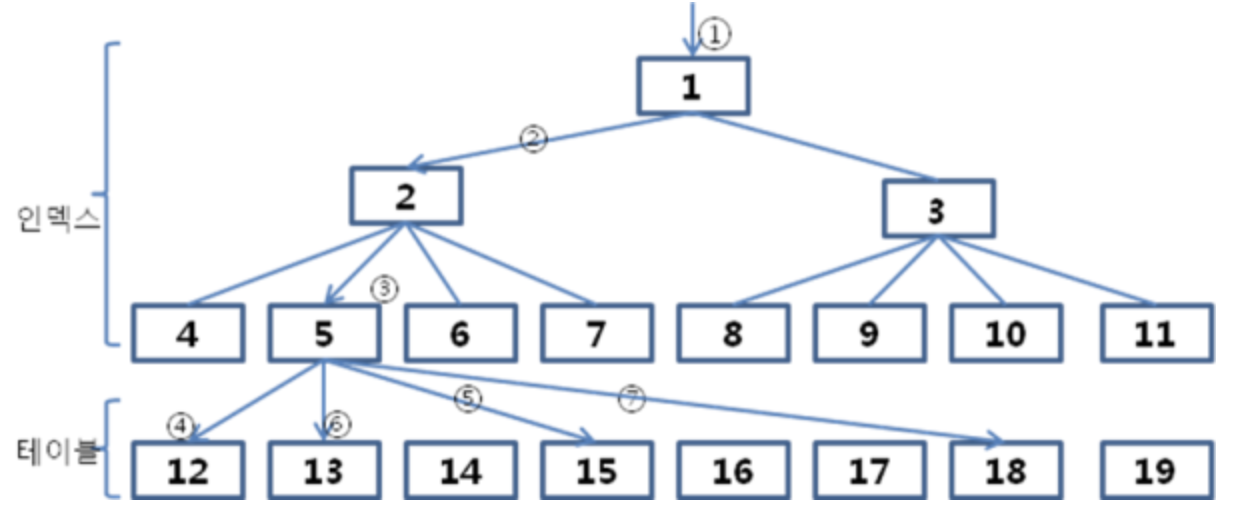

- 테이블 Prefetch = 테이블 Lookup Prefetch = 데이터 블록 Prefetch
- 인덱스를 경유해 테이블 레코드를 엑세스하는 도중 디스크에서 캐시로 블록을 적재해야 하는 상황이 발생할 때, 다른 테이블 블록까지 미리 적재해 두는 기능.

<br>

1. ex 위의 그림의 예시
- 리프 블록에 있는 인덱스 레코드는 논리적인 순서를 따라 읽음.

- 읽는 도중에 디스크 I/O가 필요해지면 현재 읽던 리프 블록 내에서 앞으로 액세스해야 할 테이블 블록 주소 목록을 미리 취합 할 수 있음.

- ① -> ② -> ③ -> ④ -> ⑤ -> ⑥ -> ⑦순서로 진행.

- 5번 인덱스 리프 블록을 읽고 12번 테이블 블록을 읽으려는 시점에 12번 블록이 버퍼 캐시에 없으면 물리적 디스크 I/O가 필요.

- 이때, 13, 15, 18번 블록까지 같이 적재해 놓는다면 ⑤,⑥,⑦번 액세스 시에 디스크 I/O 때문에 대기하지 않아도 됨.

<br>

2. 테이블 Prefetch 기능이 효과적인 경우

- Random 액세스 성능을 향상시키려고 버퍼 Pinning과 테이블 Prefetch 같은 기능을 사용.

- 버퍼 Pinning은 Random 액세스에 의한 논리적 블록 요청 횟수를 감소시킴.

- 테이블 Prefetch는 디스크 I/O에 의한 대기 횟수를 감소시킴.

- 인덱스 클러스터링 팩터가 나쁠 때 특히 효과적으로 사용.
  - 클러스터링 팩터가 나쁘면 논리적 I/O가 증가할 뿐 아니라 디스크 I/O도 많이 발생하기 때문.

<br>

3. 테이블 Prefetch를 제어하는 파라미터
- _table_lookup_prefetrch_size : 기본 값은 40.
- _table_lookup_prefetch_thresh : 기본값은 2.
- _multi_join_key_table_lookup : 기본값은 TRUE.